In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np

<font color = 'blue'>**MLP Model with Dropout Layer**

In [ ]:
class DropoutMLP(nn.Module):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2, dropout):
        super(DropoutMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(), nn.Linear(28*28, num_hiddens_1), nn.ReLU(),
            nn.Linear(num_hiddens_1, num_hiddens_2), nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(num_hiddens_2, num_outputs))

        self.dropout_rate = dropout

    def forward(self, x):
        return self.net(x)

<font color = 'blue'>**Training Function**

In [ ]:
def train_model(model, train_loader, loss_fn, optimizer, device):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs.view(-1, 28*28))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    return

<font color = 'blue'>**Evaluation Function**

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples

    return accuracy

<font color = 'blue'>**Experiment function**

In [ ]:
def run_experiment(hparams, epochs, loss_fn, device, k=5):
    batch_size = 256

    # Load dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    validation_size = int(0.1 * len(mnist_dataset))  # 10% of the training set
    mnist_train, mnist_val = random_split(mnist_dataset, [len(mnist_dataset) - validation_size, validation_size])
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
    mnist_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)


    # Original model
    original_model = DropoutMLP(**hparams).to(device)
    original_optimizer = torch.optim.Adam(original_model.parameters())

    # Training loop
    for epoch in range(epochs):
        train_model(original_model, train_loader, loss_fn, original_optimizer, device)

    # Evaluate the original model
    train_accuracy_original = evaluate_model(original_model, train_loader, device)
    #val_accuracy_original = evaluate_model(original_model, val_loader, device)
    test_accuracy_original = evaluate_model(original_model, test_loader, device)

    print("Train accuracy for original model is:", train_accuracy_original)
    # print("Validation accuracy for original model is:", val_accuracy_original)
    print("Test accuracy for original model is:", test_accuracy_original)

    # K dropout models
    best_model = DropoutMLP(**hparams).to(device)

    for epoch in range(epochs):
        models_and_performance = []

        for model_idx in range(k):
            current_model = DropoutMLP(**hparams).to(device)
            current_model.load_state_dict(best_model.state_dict())
            current_model.train()
            current_model.dropout_rate = torch.rand(1).item()

            optimizer = torch.optim.Adam(current_model.parameters())

            train_model(current_model, train_loader, loss_fn, optimizer, device)

            accuracy = evaluate_model(current_model, val_loader, device)

            models_and_performance.append((current_model, accuracy))

        best_model, best_accuracy = max(models_and_performance, key=lambda x: x[1])

       # print(f'Epoch {epoch + 1}/{epochs}, Best Model Validation Accuracy: {best_accuracy}, Dropout Rate: {best_model.dropout_rate}')

    train_accuracy = evaluate_model(best_model, train_loader, device)
    print("Train accuracy for K dropout mask model is:", train_accuracy)

    # Test the final model on the test set
    test_accuracy = evaluate_model(best_model, test_loader, device)
    print("Test accuracy for K dropout mask model is:", test_accuracy)

    train_accuracy_improvement = (train_accuracy - train_accuracy_original)/train_accuracy_original
    test_accuracy_improvement = (test_accuracy - test_accuracy_original)/test_accuracy_original

    return train_accuracy_improvement, test_accuracy_improvement

<font color = 'blue'>**Multi-Experiment Analysis: MLP Model with Dropout on FashionMNIST**

In [ ]:
hparams = {'num_outputs': 10, 'num_hiddens_1': 256, 'num_hiddens_2': 256, 'dropout': 0.5}
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss()

# Run multiple experiments and calculate margins of error
num_experiments = 20
train_accuracies = []
test_accuracies = []

for experiment in range(num_experiments):
    print('\n' f"Running Experiment {experiment + 1}/{num_experiments}")

    train_accuracy_improvements, test_accuracy_improvements = run_experiment(hparams, epochs, loss_fn, device)
    train_accuracies.append(train_accuracy_improvements)
    test_accuracies.append(test_accuracy_improvements)

train_improvement_mean = np.mean(train_accuracies)
train_improvement_std_dev = np.std(train_accuracies)
train_improvement_margin_of_error = 1.96 * (train_improvement_std_dev / np.sqrt(num_experiments))

test_improvement_mean = np.mean(test_accuracies)
test_improvement_std_dev = np.std(test_accuracies)
test_improvement_margin_of_error = 1.96 * (test_improvement_std_dev / np.sqrt(num_experiments))

print("\nAccuracy Improvement Statistics:")
print(f"Train Improvement: Mean={train_improvement_mean}, Std Dev={train_improvement_std_dev}, Margin of Error={train_improvement_margin_of_error}")
print(f"Test Improvement: Mean={test_improvement_mean}, Std Dev={test_improvement_std_dev}, Margin of Error={test_improvement_margin_of_error}")



Running Experiment 1/20
Train accuracy for original model is: 0.9078703703703703
Test accuracy for original model is: 0.876
Train accuracy for K dropout mask model is: 0.9183148148148148
Test accuracy for K dropout mask model is: 0.8831

Running Experiment 2/20
Train accuracy for original model is: 0.9177407407407407
Test accuracy for original model is: 0.8825
Train accuracy for K dropout mask model is: 0.9148333333333334
Test accuracy for K dropout mask model is: 0.882

Running Experiment 3/20
Train accuracy for original model is: 0.9154814814814815
Test accuracy for original model is: 0.881
Train accuracy for K dropout mask model is: 0.9179814814814815
Test accuracy for K dropout mask model is: 0.8849

Running Experiment 4/20
Train accuracy for original model is: 0.9148703703703703
Test accuracy for original model is: 0.8849
Train accuracy for K dropout mask model is: 0.9185740740740741
Test accuracy for K dropout mask model is: 0.8817

Running Experiment 5/20
Train accuracy for ori

In [ ]:
print ("Train accuracies improvement", train_accuracies)
print ("Test accuracies improvement",test_accuracies)


Train accuracies improvement [0.011504334523202486, -0.0031680051656644208, 0.002730803463063418, 0.004048337145517545, -0.001255543630141117, -0.0021389511068062835, 0.004915102770330584, 0.004092631237717009, 0.004857624845023495, 0.00082927125260409, 0.0016387141151954737, 0.0024358557973368136, 0.0032397845543271175, -0.0043225337319222155, 0.012583995113011523, 0.006391857506361338, 0.016451810926948994, -0.0008110793438367756, 0.01055247718383312, 0.008935128518971802]
Test accuracies improvement [0.008105022831050223, -0.0005665722379602776, 0.004426787741203195, -0.003616227822352786, 0.0036380172805820605, -0.001808522663049673, 0.004552697473252906, 0.0014760985579652184, 0.003190883190883219, 0.0026097810053331214, 0.0028392958546281178, 0.006736697876227468, 0.0021527305687739653, -0.0056516333220300715, 0.011536264991433592, 0.004680899646078311, 0.009366076527698568, 0.004447992700729943, 0.012023359670216496, 0.007878511075588053]


<font color = 'blue'>**Box plots for train and test improvements**

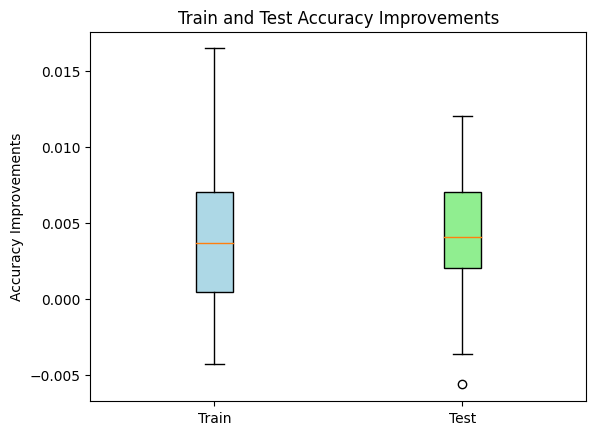

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

train_box = ax.boxplot(train_accuracies, positions=[1], patch_artist=True)
test_box = ax.boxplot(test_accuracies, positions=[2], patch_artist=True)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Train', 'Test'])
ax.set_ylabel('Accuracy Improvements')
ax.set_title('Train and Test Accuracy Improvements')

colors = ['lightblue', 'lightgreen']
for box, color in zip([train_box, test_box], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

plt.show()